# FUSION-TWAS
- Prepare input expression file
- h2 filter
- Make TWAS plot

In [3]:
library(data.table)
library(dplyr)
library(ggplot2)
library(patchwork)
library(ggrepel)

In [2]:
setwd("~/project-gandalm/isoform_twas/TWAS/")

## 1: Prepare input files
Follow GEUVADIS example data. Regress by covariates with optimal number of HCP. Exclude genes without cis-variants, or with 1 cis-variant (got error in compute weights step).
### 1-1: Write regressed gene expression file

**EUR**

In [3]:
datExpr <- fread("../eqtl_new/data/eur/gene.counts.scaled.normalized.bed.gz", data.table = F)

In [4]:
info <- datExpr[,1:4]

In [5]:
datExpr <- datExpr[,5:ncol(datExpr)]

In [6]:
rel <- read.table("../genotype/all_data/isec_R2_greater_than_3/ancestry/related.txt", header = F, stringsAsFactors = F)$V1

In [7]:
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)

[1] 31947   280

In [8]:
cov <- read.table("../eqtl_new/data/eur/50HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)

In [9]:
rownames(cov) <- cov$id
cov <- cov[,-1]
cov <- cov[,!names(cov) %in% rel]
dim(cov)

[1]  57 280

In [10]:
cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

In [11]:
cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

In [12]:
dat <- cbind(info, datExpr_regressed)
dat$end <- dat$ID
colnames(dat)[1:4] <- c("Chr","Coord","TargetID","Gene_Symbol")

In [13]:
head(dat)

,Chr,Coord,TargetID,Gene_Symbol,898,1038,1046,1102,1107,1110,⋯,RNAID1922,RNAID1936,RNAID1938,RNAID1939,RNAID1944,RNAID1952,RNAID1974,RNAID1983,RNAID1987,RNAID2144
,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,11868,ENSG00000223972,ENSG00000223972,2.565564,3.6053417,1.8360737,1.9991702,1.904191,3.5480882,⋯,2.132243,3.3003805,3.177607,3.5299871,2.848982,4.073260,2.0589195,3.457027,2.875230,2.002251
2,1,29553,ENSG00000243485,ENSG00000243485,2.819398,1.0959469,2.8483054,2.1622183,1.571914,1.7570492,⋯,1.433819,2.6111706,1.270131,3.1224558,1.802944,1.197524,3.4933517,1.986875,2.338058,2.558506
3,1,29569,ENSG00000227232,ENSG00000227232,8.340482,8.7758971,9.3344082,8.3531372,8.590556,8.7678620,⋯,8.770681,8.2024261,7.868934,8.7785143,8.892686,8.820818,8.2291373,9.059215,8.577134,8.435131
4,1,36080,ENSG00000237613,ENSG00000237613,3.901713,3.1812980,3.1201478,4.1157479,3.414270,4.7278982,⋯,0.557910,3.9508007,2.696453,3.7811057,4.542311,4.005088,2.7271515,1.380424,3.161670,4.537650
5,1,91104,ENSG00000239945,ENSG00000239945,1.720500,0.5282807,0.5575717,0.6424397,1.850878,-0.2967324,⋯,1.929382,-0.4598936,2.152505,0.9581094,1.473670,1.593463,0.6791255,0.365894,0.664181,1.591270
6,1,131024,ENSG00000233750,ENSG00000233750,5.220183,4.4191885,3.8402640,4.3866399,5.164541,4.8757581,⋯,4.957508,4.0326060,4.023465,4.7190258,4.536816,3.629671,4.2418672,4.279393,4.052386,4.469380


In [15]:
dim(dat)

[1] 31947   284

In [16]:
dat <- dat[,c(3,4,1,2,5:ncol(dat))]

### 1-2: Write ID file
Note FID is IID, not 0. BIM file is like that.

In [17]:
ID <- data.frame(colnames(dat)[5:ncol(dat)], colnames(dat)[5:ncol(dat)])
head(ID)

,colnames.dat..5.ncol.dat..,colnames.dat..5.ncol.dat...1
,<fct>,<fct>
1,898,898
2,1038,1038
3,1046,1046
4,1102,1102
5,1107,1107
6,1110,1110


In [18]:
dim(ID)

[1] 280   2

In [20]:
write.table(ID, "data/eur_gene_exp_regressed.txt.ID", col.names = F, row.names = F, quote = F, sep = "\t")

### 1-3: Exclude genes with 0 or 1 cis SNP

In [22]:
results <- fread("../eqtl_new/results/eur_perm_50HCP/all.chunks.txt.gz", data.table = F)

In [23]:
dim(results)

[1] 31947    11

In [24]:
sum(results$V2%in%c(0,1))

[1] 417

In [25]:
results <- results %>% filter(V2 > 1)
dim(results)

[1] 31530    11

In [26]:
dat <- dat %>% filter(TargetID %in% results$V1)

In [28]:
dim(dat)

[1] 31530   284

In [29]:
write.table(dat, "data/eur_gene_exp_regressed.txt", col.names = T, row.names = F, quote = F, sep = "\t")

**AMR**

In [30]:
datExpr <- fread("../eqtl_new/data/amr/gene.counts.scaled.normalized.bed.gz", data.table = F)
info <- datExpr[,1:4]
datExpr <- datExpr[,5:ncol(datExpr)]
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)

cov <- read.table("../eqtl_new/data/amr/15HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]
cov <- cov[,!names(cov) %in% rel]
dim(cov)
cov[cov=="F"] <- 0
cov[cov=="M"] <- 1
cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

dat <- cbind(info, datExpr_regressed)
dat$end <- dat$ID
colnames(dat)[1:4] <- c("Chr","Coord","TargetID","Gene_Symbol")
dim(dat)
dat <- dat[,c(3,4,1,2,5:ncol(dat))]

ID <- data.frame(colnames(dat)[5:ncol(dat)], colnames(dat)[5:ncol(dat)])
write.table(ID, "data/amr_gene_exp_regressed.txt.ID", col.names = F, row.names = F, quote = F, sep = "\t")

results <- fread("../eqtl_new/results/amr_perm_15HCP/all.chunks.txt.gz", data.table = F)
results <- results %>% filter(V2 > 1)
dat <- dat %>% filter(TargetID %in% results$V1)
dim(dat)
write.table(dat, "data/amr_gene_exp_regressed.txt", col.names = T, row.names = F, quote = F, sep = "\t")

[1] 31947   162

[1]  22 162

[1] 31947   166

[1] 31531   166

**AFR**

In [31]:
datExpr <- fread("../eqtl_new/data/afr/gene.counts.scaled.normalized.bed.gz", data.table = F)
info <- datExpr[,1:4]
datExpr <- datExpr[,5:ncol(datExpr)]
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)

cov <- read.table("../eqtl_new/data/afr/25HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]
cov <- cov[,!names(cov) %in% rel]
dim(cov)
cov[cov=="F"] <- 0
cov[cov=="M"] <- 1
cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

dat <- cbind(info, datExpr_regressed)
dat$end <- dat$ID
colnames(dat)[1:4] <- c("Chr","Coord","TargetID","Gene_Symbol")
dim(dat)
dat <- dat[,c(3,4,1,2,5:ncol(dat))]

ID <- data.frame(colnames(dat)[5:ncol(dat)], colnames(dat)[5:ncol(dat)])
write.table(ID, "data/afr_gene_exp_regressed.txt.ID", col.names = F, row.names = F, quote = F, sep = "\t")

results <- fread("../eqtl_new/results/afr_perm_25HCP/all.chunks.txt.gz", data.table = F)
results <- results %>% filter(V2 > 1)
dat <- dat %>% filter(TargetID %in% results$V1)
dim(dat)
write.table(dat, "data/afr_gene_exp_regressed.txt", col.names = T, row.names = F, quote = F, sep = "\t")

[1] 31947   135

[1]  32 135

[1] 31947   139

[1] 31531   139

## 2: h2

In [3]:
hsq_eur <- fread("results/gene_eur/hsq/concat_hsq.txt", data.table = F)
hsq_eur_rn <- fread("results/gene_eur_rn/hsq/concat_hsq.txt", data.table = F)
hsq_amr <- fread("results/gene_amr/hsq/concat_hsq.txt", data.table = F)
hsq_amr_rn <- fread("results/gene_amr_rn/hsq/concat_hsq.txt", data.table = F)
hsq_afr <- fread("results/gene_afr/hsq/concat_hsq.txt", data.table = F)
hsq_afr_rn <- fread("results/gene_afr_rn/hsq/concat_hsq.txt", data.table = F)

In [4]:
# NAs are GCTA not converging, skipping those features
dim(hsq_eur[complete.cases(hsq_eur),])
dim(hsq_eur_rn[complete.cases(hsq_eur_rn),])
dim(hsq_amr[complete.cases(hsq_amr),])
dim(hsq_amr_rn[complete.cases(hsq_amr_rn),])
dim(hsq_afr[complete.cases(hsq_afr),])
dim(hsq_afr_rn[complete.cases(hsq_afr_rn),])

[1] 30016     4

[1] 30071     4

[1] 28969     4

[1] 28936     4

[1] 29759     4

[1] 29667     4

In [5]:
hsq_eur <- hsq_eur %>% filter(complete.cases(hsq_eur))
hsq_eur_rn <- hsq_eur_rn %>% filter(complete.cases(hsq_eur_rn))
hsq_amr <- hsq_amr %>% filter(complete.cases(hsq_amr))
hsq_amr_rn <- hsq_amr_rn %>% filter(complete.cases(hsq_amr_rn))
hsq_afr <- hsq_afr %>% filter(complete.cases(hsq_afr))
hsq_afr_rn <- hsq_afr_rn %>% filter(complete.cases(hsq_afr_rn))

In [6]:
colnames(hsq_eur) <- colnames(hsq_eur_rn) <- colnames(hsq_amr) <- colnames(hsq_amr_rn) <- colnames(hsq_afr) <- colnames(hsq_afr_rn) <- c("gene","h2","se","pval")

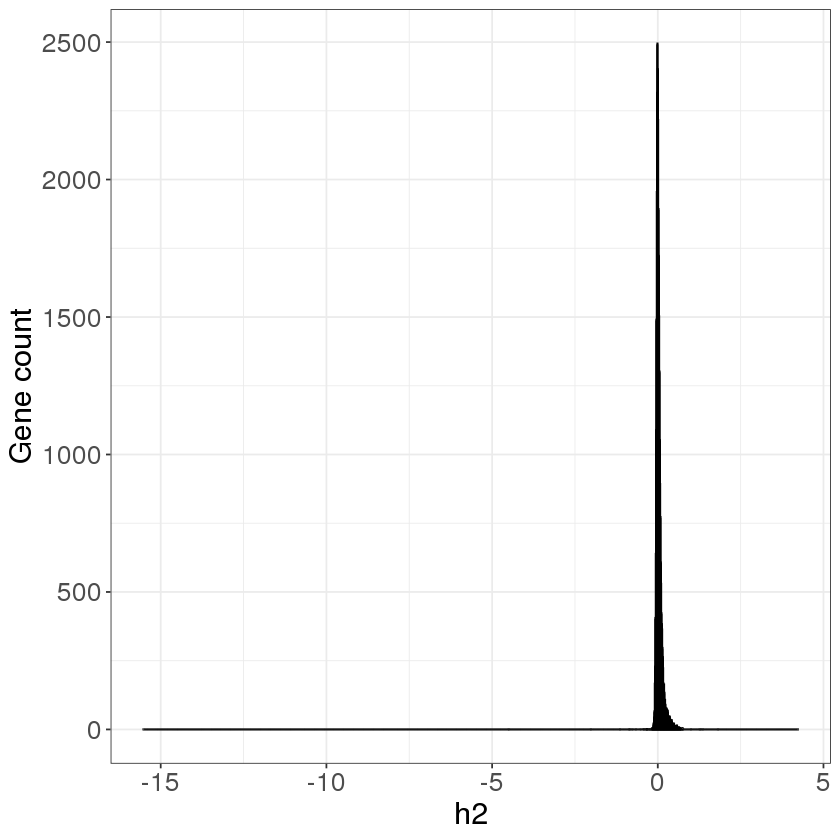

In [7]:
p <- ggplot(hsq_eur, aes(x = h2)) +
    geom_histogram(binwidth = 0.01, color = "black", fill = "white") +
    theme_bw() +
    labs(x = "h2", y = "Gene count") +
    theme(axis.text = element_text(size=16),
          axis.title = element_text(size=18))
p

In [8]:
# sig pval, positive h2 gene list
sig_eur <- hsq_eur %>% filter(pval < .05, h2 > 0) %>% select(gene)
sig_eur_rn <- hsq_eur_rn %>% filter(pval < .05, h2 > 0) %>% select(gene)
sig_amr <- hsq_amr %>% filter(pval < .05, h2 > 0) %>% select(gene)
sig_amr_rn <- hsq_amr_rn %>% filter(pval < .05, h2 > 0) %>% select(gene)
sig_afr <- hsq_afr %>% filter(pval < .05, h2 > 0) %>% select(gene)
sig_afr_rn <- hsq_afr_rn %>% filter(pval < .05, h2 > 0) %>% select(gene)

In [9]:
hsq_eur_sig <- hsq_eur %>% filter(gene %in% sig_eur$gene)
hsq_eur_rn_sig <- hsq_eur_rn %>% filter(gene %in% sig_eur_rn$gene)
hsq_amr_sig <- hsq_amr %>% filter(gene %in% sig_amr$gene)
hsq_amr_rn_sig <- hsq_amr_rn %>% filter(gene %in% sig_amr_rn$gene)
hsq_afr_sig <- hsq_afr %>% filter(gene %in% sig_afr$gene)
hsq_afr_rn_sig <- hsq_afr_rn %>% filter(gene %in% sig_afr_rn$gene)

In [19]:
dim(hsq_afr_sig)

[1] 3252    4

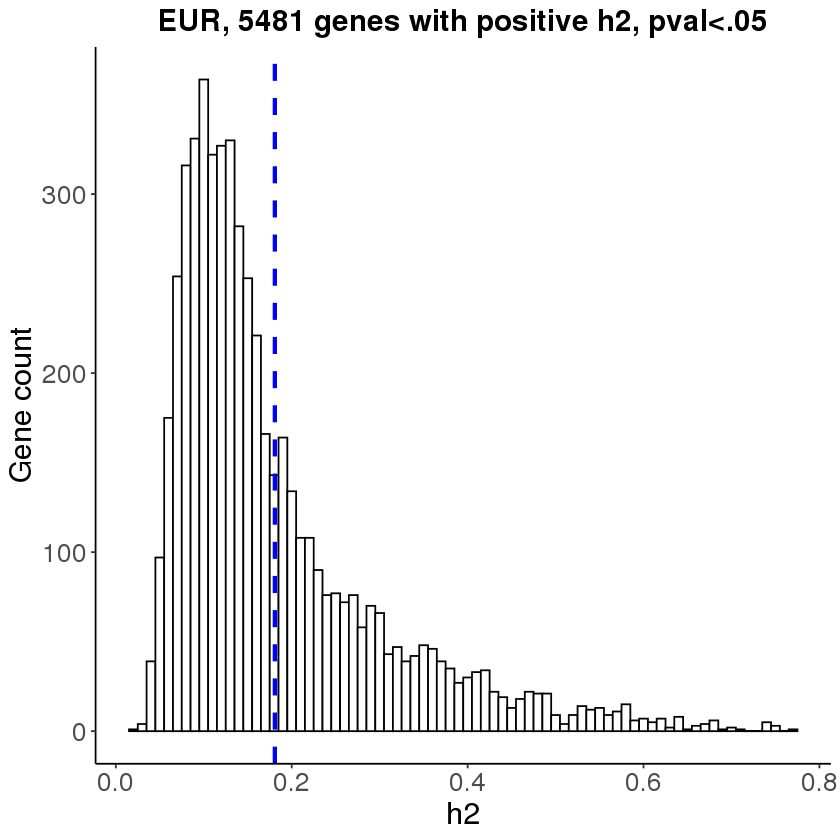

In [16]:
p1 <- ggplot(hsq_eur_sig, aes(x = h2)) +
    geom_histogram(binwidth = 0.01, color = "black", fill = "white") +
    theme_classic() +
    labs(x = "h2", y = "Gene count", title = "EUR, 5481 genes with positive h2, pval<.05") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 18, face = "bold", hjust = .5)) +
    geom_vline(xintercept = mean(hsq_eur_sig$h2), linetype = "dashed", color = "blue", size = 1.2)
p1

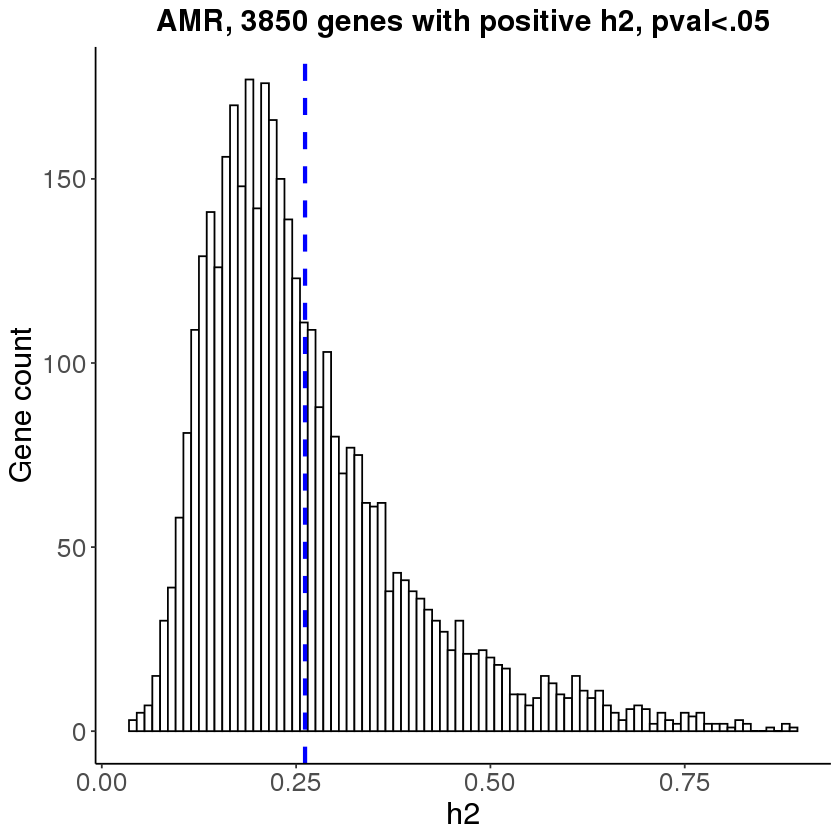

In [18]:
p2 <- ggplot(hsq_amr_sig, aes(x = h2)) +
    geom_histogram(binwidth = 0.01, color = "black", fill = "white") +
    theme_classic() +
    labs(x = "h2", y = "Gene count", title = "AMR, 3850 genes with positive h2, pval<.05") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 18, face = "bold", hjust = .5)) +
    geom_vline(xintercept = mean(hsq_amr_sig$h2), linetype = "dashed", color = "blue", size = 1.2)
p2

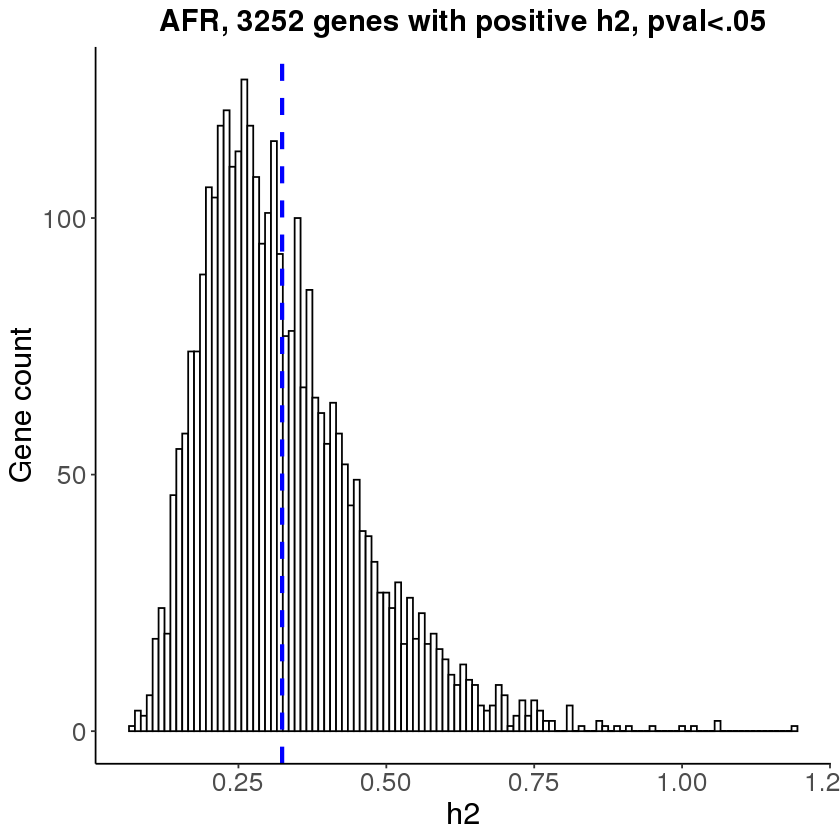

In [20]:
p3 <- ggplot(hsq_afr_sig, aes(x = h2)) +
    geom_histogram(binwidth = 0.01, color = "black", fill = "white") +
    theme_classic() +
    labs(x = "h2", y = "Gene count", title = "AFR, 3252 genes with positive h2, pval<.05") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 18, face = "bold", hjust = .5)) +
    geom_vline(xintercept = mean(hsq_afr_sig$h2), linetype = "dashed", color = "blue", size = 1.2)
p3

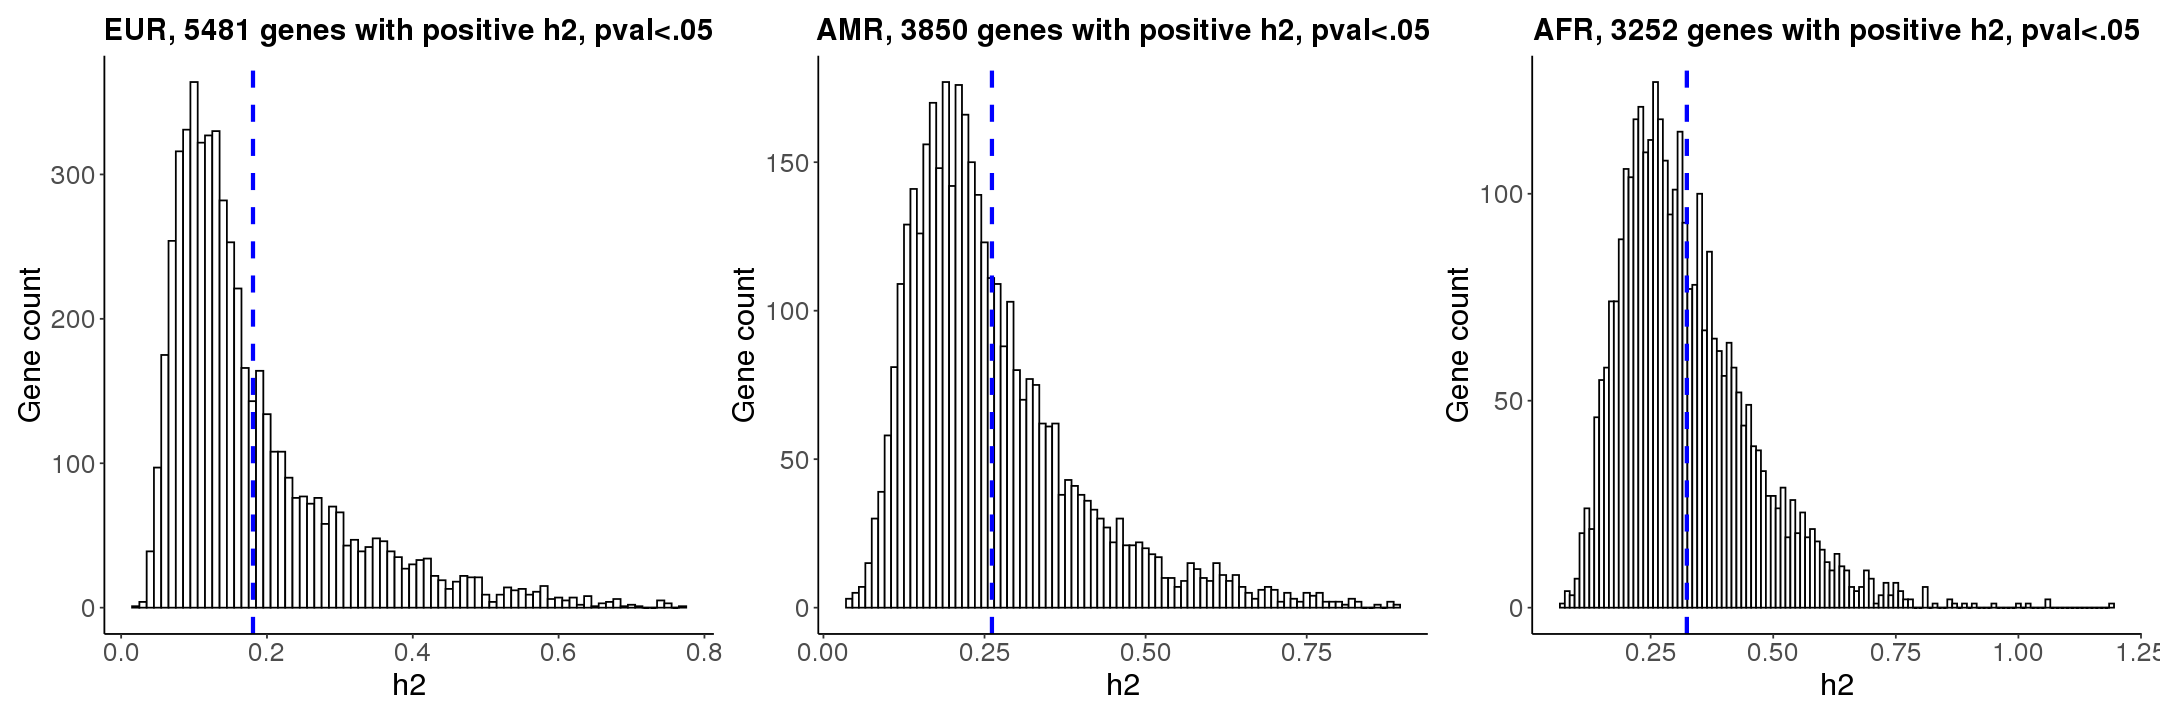

In [22]:
options(repr.plot.width = 18, repr.plot.height = 6)

p <- p1 + p2 + p3 +
    plot_layout(ncol = 3) 
#     plot_annotation(tag_level = 'A') &
#         theme(plot.tag = element_text(size = 18, face = "bold"))
p

In [25]:
dim(hsq_eur_rn_sig)
dim(hsq_amr_rn_sig)
dim(hsq_afr_rn_sig)

[1] 5490    4

[1] 3661    4

[1] 3244    4

In [28]:
p4 <- ggplot(hsq_eur_rn_sig, aes(x = h2)) +
    geom_histogram(binwidth = 0.01, color = "black", fill = "white") +
    theme_classic() +
    labs(x = "h2", y = "Gene count", title = "EUR, 5490 genes with positive h2, pval<.05",
         subtitle = "Rank normalized") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 18, face = "bold", hjust = .5),
          plot.subtitle = element_text(size = 16, hjust = .5)) +
    geom_vline(xintercept = mean(hsq_eur_rn_sig$h2), linetype = "dashed", color = "blue", size = 1.2)

p5 <- ggplot(hsq_amr_rn_sig, aes(x = h2)) +
    geom_histogram(binwidth = 0.01, color = "black", fill = "white") +
    theme_classic() +
    labs(x = "h2", y = "Gene count", title = "AMR, 3661 genes with positive h2, pval<.05",
         subtitle = "Rank normalized") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 18, face = "bold", hjust = .5),
          plot.subtitle = element_text(size = 16, hjust = .5)) +
    geom_vline(xintercept = mean(hsq_amr_rn_sig$h2), linetype = "dashed", color = "blue", size = 1.2)

p6 <- ggplot(hsq_afr_rn_sig, aes(x = h2)) +
    geom_histogram(binwidth = 0.01, color = "black", fill = "white") +
    theme_classic() +
    labs(x = "h2", y = "Gene count", title = "AFR, 3244 genes with positive h2, pval<.05",
         subtitle = "Rank normalized") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 18, face = "bold", hjust = .5),
          plot.subtitle = element_text(size = 16, hjust = .5)) +
    geom_vline(xintercept = mean(hsq_afr_rn_sig$h2), linetype = "dashed", color = "blue", size = 1.2)

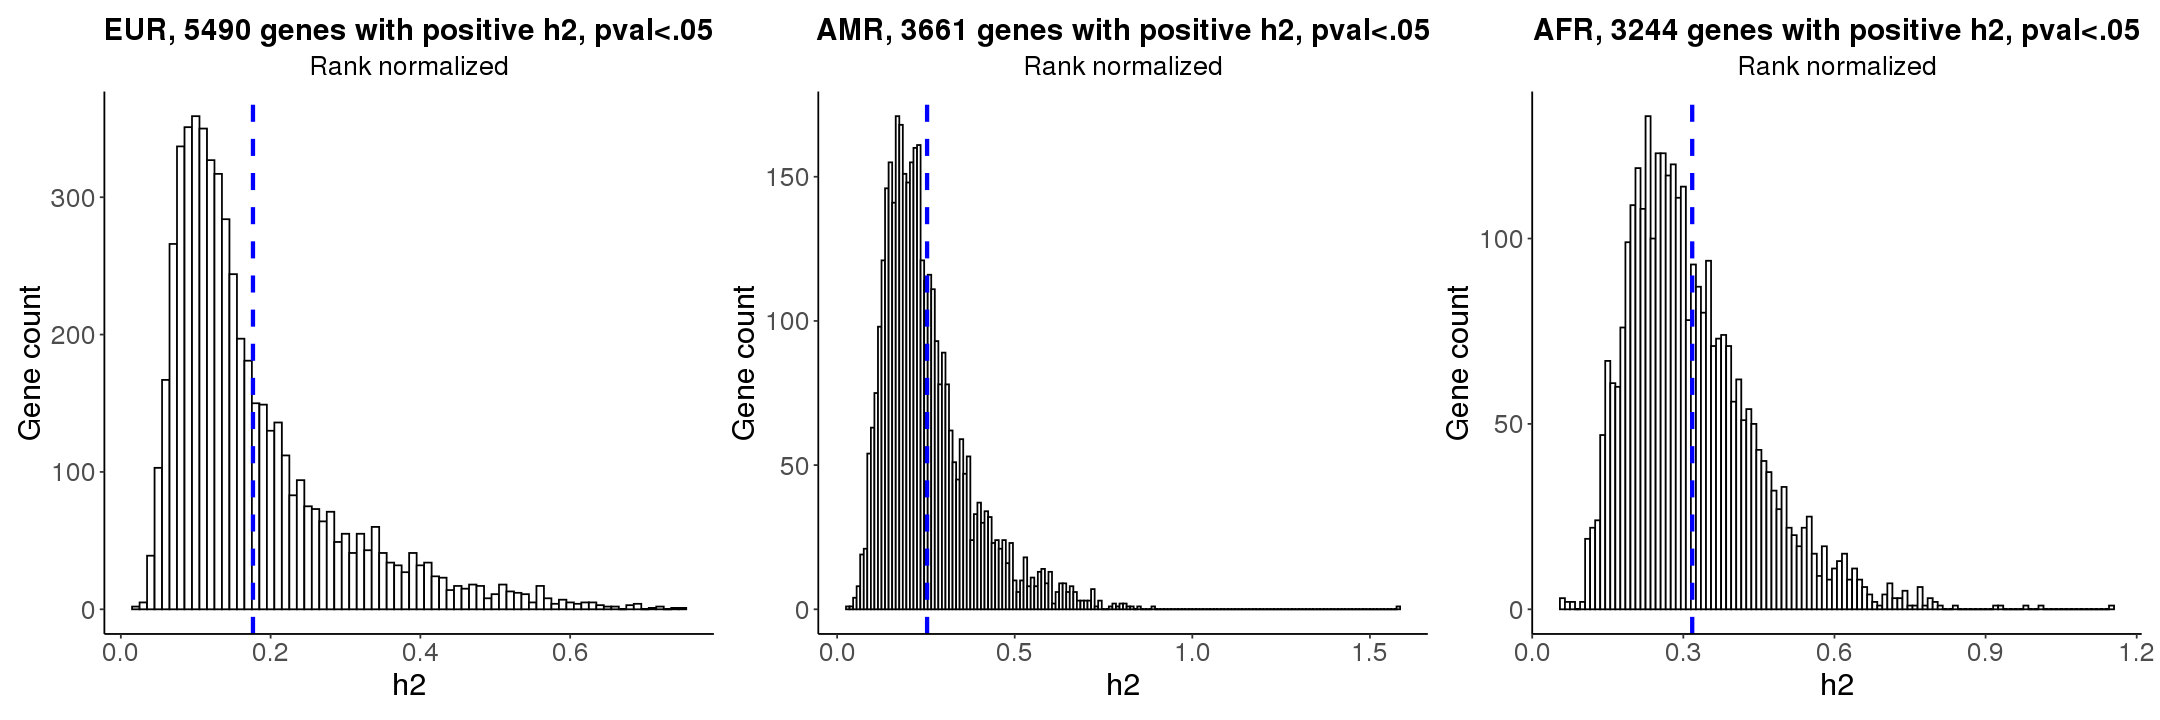

In [29]:
p7 <- p4 + p5 + p6 +
    plot_layout(ncol = 3) 
#     plot_annotation(tag_level = 'A') &
#         theme(plot.tag = element_text(size = 18, face = "bold"))
p7

In [30]:
ggsave("figures/gcta_h2g.png", p, height = 6, width = 18)
ggsave("figures/gcta_h2g_rn.png", p7, height = 6, width = 18)

## 3: Association plot
Adapted from https://github.com/opain/TWAS-plotter/blob/master/TWAS-plotter.V1.0.r

### 3-1. load TWAS assoc results, all chr

In [93]:
dat <- fread("results/gene_eur/assoc/PGC.SCZ.1000perm.5481test.all.chr", data.table = F)
dim(dat)
dat <- dat[order(dat$CHR, dat$P0), ]
dat <- dat %>% filter(!is.na(TWAS.P))
head(dat)
dim(dat)

[1] 5377   28

,PANEL,FILE,ID,CHR,P0,P1,HSQ,BEST.GWAS.ID,BEST.GWAS.Z,EQTL.ID,⋯,TWAS.Z,TWAS.P,COLOC.PP0,COLOC.PP1,COLOC.PP2,COLOC.PP3,COLOC.PP4,PERM.PV,PERM.N,PERM.ANL_PV
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,eur,/u/project/gandalm/cindywen/isoform_twas/TWAS/results/gene_eur/WEIGHTS/ENSG00000269896.wgt.RDat,AL513477.1,1,2280000,2280000,0.1930,rs4648845,6.86,chr1:2367872,⋯,-0.739304,0.46000,NA,NA,NA,NA,NA,0.00,0,0
2,eur,/u/project/gandalm/cindywen/isoform_twas/TWAS/results/gene_eur/WEIGHTS/ENSG00000272420.wgt.RDat,AL513477.2,1,2300000,2300000,0.1976,rs4648845,6.86,rs10910055,⋯,0.994042,0.32000,NA,NA,NA,NA,NA,0.00,0,0
3,eur,/u/project/gandalm/cindywen/isoform_twas/TWAS/results/gene_eur/WEIGHTS/ENSG00000215912.wgt.RDat,TTC34,1,2720000,2720000,0.1163,rs4648845,6.86,rs78506337,⋯,2.971505,0.00296,0,0,0.074,0.923,0.003,0.15,80,NA
4,eur,/u/project/gandalm/cindywen/isoform_twas/TWAS/results/gene_eur/WEIGHTS/ENSG00000142611.wgt.RDat,PRDM16,1,2990000,2990000,0.1172,rs4648845,6.86,rs144128055,⋯,0.208604,0.83500,NA,NA,NA,NA,NA,0.00,0,0
5,eur,/u/project/gandalm/cindywen/isoform_twas/TWAS/results/gene_eur/WEIGHTS/ENSG00000130762.wgt.RDat,ARHGEF16,1,3370000,3370000,0.2858,rs4648845,6.86,rs4648389,⋯,-0.766554,0.44300,NA,NA,NA,NA,NA,0.00,0,0
6,eur,/u/project/gandalm/cindywen/isoform_twas/TWAS/results/gene_eur/WEIGHTS/ENSG00000162591.wgt.RDat,MEGF6,1,3530000,3530000,0.2389,rs7518852,4.74,rs12743246,⋯,-0.482676,0.62900,NA,NA,NA,NA,NA,0.00,0,0


[1] 5071   28

In [94]:
sig <- fread("results/gene_eur/assoc/PGC.SCZ.1000perm.5481test.all.chr.sig", data.table = F)

In [95]:
dim(sig)

[1] 96 28

### 3-2. get coordinates in genome

In [96]:
ticks <- NULL
lastbase <- 0
dat$pos <- NA

for (i in unique(dat$CHR)) {
  if (i==1) {
    dat[dat$CHR==i, ]$pos <- dat[dat$CHR==i, ]$P0
  }	else {
    lastbase <- lastbase + tail(subset(dat,CHR==i-1)$P0, 1)
    dat[dat$CHR==i, ]$pos <- dat[dat$CHR==i, ]$P0 + lastbase
  }
  ticks <- c(ticks, dat[dat$CHR==i, ]$pos[floor(length(dat[dat$CHR==i, ]$pos)/2)+1])
}
ticklim <- c(min(dat$pos), max(dat$pos))

### 3-3. Z-score plot

In [97]:
# sig with pos
sig2 <- dat %>% filter(FILE %in% sig$FILE)
dim(sig2)
length(unique(sig$ID))

[1] 96 29

[1] 96

In [98]:
sig_perm <- sig %>% filter(sig$PERM.PV < 0.05/nrow(sig))
dim(sig_perm)

[1] 14 28

In [99]:
sig2$perm_pass <- ifelse(sig2$FILE %in% sig_perm$FILE, 1, 0)
table(sig2$perm_pass)


 0  1 
82 14 

In [100]:
dat$color_group <- ifelse(dat$CHR%%2 == 1, 1, 2)
for (i in 1:nrow(dat)) {
    if (dat[i,'FILE'] %in% sig$FILE) {
        dat[i,'color_group'] <- 3
    }
    if (dat[i,'FILE'] %in% sig_perm$FILE) {
        dat[i,'color_group'] <- 4
    }
}

In [101]:
table(dat$color_group)


   1    2    3    4 
2697 2278   82   14 

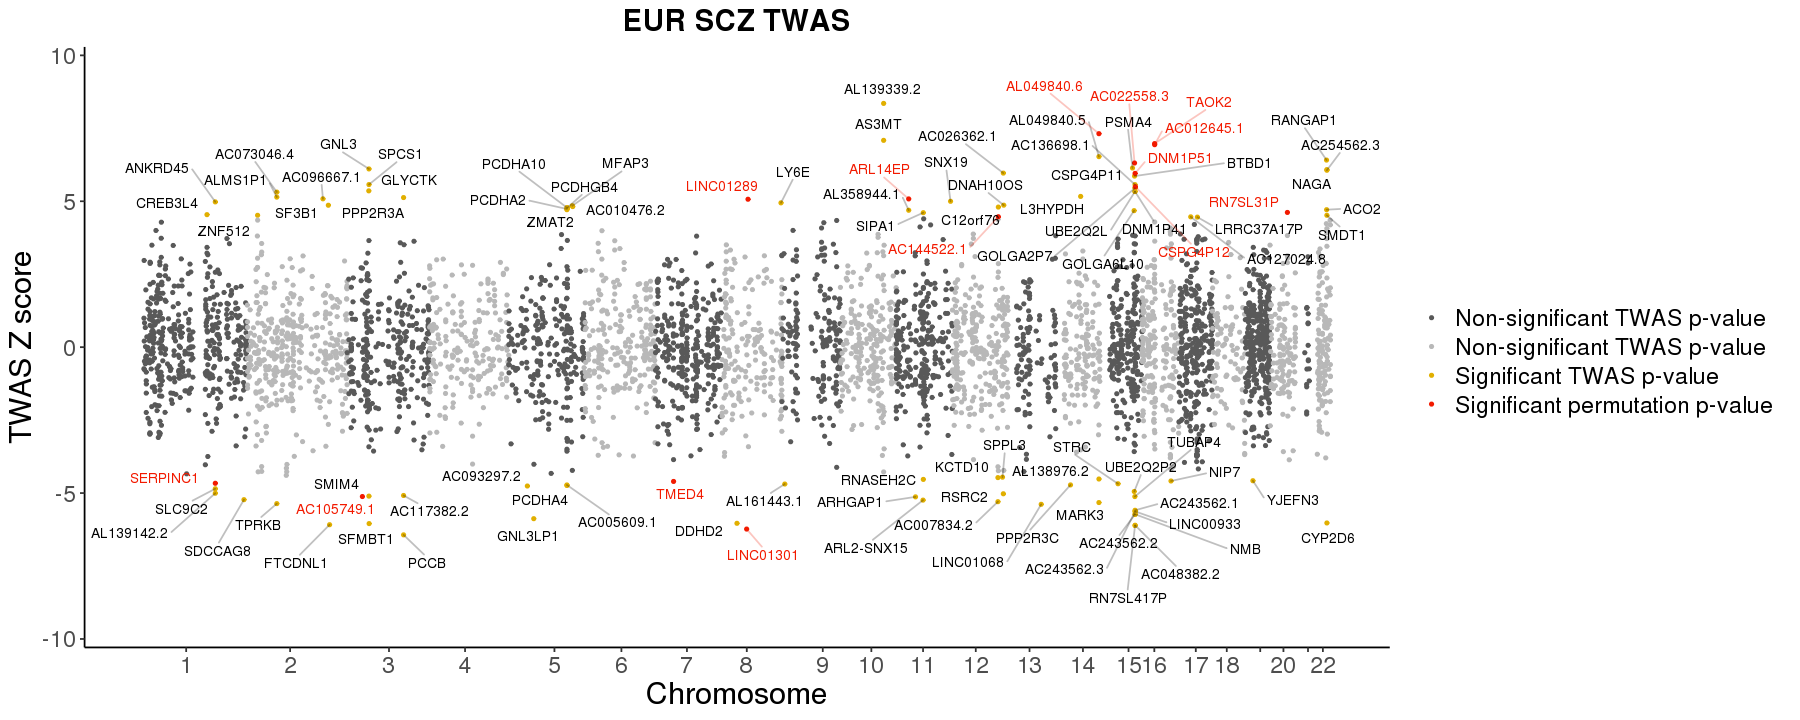

In [102]:
# chr_labs <- as.character(unique(dat$CHR))
chr_labs <- c(1:18, '', 20, '', 22)
ylimit <- max(abs(dat$TWAS.Z)) + 1
colors <- c("1" = "gray35", "2" = "gray72", "3" = "#E1AF00", "4" = "#F21A00")

options(repr.plot.height = 6, repr.plot.width = 15)

p <- ggplot(dat, aes(x = pos, y = TWAS.Z, colour = as.character(color_group))) +
  geom_point(size = 0.8) +
  scale_x_continuous(name = "Chromosome", labels = chr_labs, breaks = ticks) +
  scale_y_continuous(name = "TWAS Z score", limits = c(-ylimit, ylimit)) +
  scale_colour_manual(values = colors, 
                      labels = c("Non-significant TWAS p-value","Non-significant TWAS p-value",
                                 "Significant TWAS p-value", "Significant permutation p-value")) +
#   geom_point(data = sig2, aes(x = pos, y = TWAS.Z), 
#              colour = ifelse(sig2$perm.pass == 1, "#F21A00", "#E1AF00"), size = 0.8) +
  geom_text_repel(data = sig2, aes(x = pos, y = TWAS.Z, label = ID), 
                  colour = ifelse(sig2$perm_pass == 1, "#F21A00", "black"), 
                  nudge_y = ifelse(sig2$TWAS.Z > 0, .5, -.5), size = 3, force = 5, segment.alpha = 0.25) +
  theme_classic() +
  labs(title = "EUR SCZ TWAS", colour = "") +
  theme(axis.text = element_text(size = 14),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        legend.text = element_text(size = 14))

p

In [90]:
ggsave("figures/assoc_EUR_SCZ.png", p, width = 15, height = 6)

**Rank normalized data**

In [103]:
dat_rn <- fread("results/gene_eur_rn/assoc/PGC.SCZ.1000perm.5490test.all.chr", data.table = F)
dat_rn <- dat_rn[order(dat_rn$CHR, dat_rn$P0), ]
dat_rn <- dat_rn %>% filter(!is.na(TWAS.P))
sig_rn <- fread("results/gene_eur_rn/assoc/PGC.SCZ.1000perm.5490test.all.chr.sig", data.table = F)
dim(sig_rn)

ticks <- NULL
lastbase <- 0
dat_rn$pos <- NA

for (i in unique(dat_rn$CHR)) {
  if (i==1) {
    dat_rn[dat_rn$CHR==i, ]$pos <- dat_rn[dat_rn$CHR==i, ]$P0
  }	else {
    lastbase <- lastbase + tail(subset(dat_rn,CHR==i-1)$P0, 1)
    dat_rn[dat_rn$CHR==i, ]$pos <- dat_rn[dat_rn$CHR==i, ]$P0 + lastbase
  }
  ticks <- c(ticks, dat_rn[dat_rn$CHR==i, ]$pos[floor(length(dat_rn[dat_rn$CHR==i, ]$pos)/2)+1])
}
ticklim <- c(min(dat_rn$pos), max(dat_rn$pos))

sig2_rn <- dat_rn %>% filter(FILE %in% sig_rn$FILE)
sig_perm_rn <- sig_rn %>% filter(sig_rn$PERM.PV < 0.05/nrow(sig_rn))
dim(sig_perm_rn)

sig2_rn$perm_pass <- ifelse(sig2_rn$FILE %in% sig_perm_rn$FILE, 1, 0)
table(sig2_rn$perm_pass)

dat_rn$color_group <- ifelse(dat_rn$CHR%%2 == 1, 1, 2)
for (i in 1:nrow(dat_rn)) {
    if (dat_rn[i,'FILE'] %in% sig_rn$FILE) {
        dat_rn[i,'color_group'] <- 3
    }
    if (dat_rn[i,'FILE'] %in% sig_perm_rn$FILE) {
        dat_rn[i,'color_group'] <- 4
    }
}
table(dat_rn$color_group)

[1] 95 28

[1] 18 28


 0  1 
77 18 


   1    2    3    4 
2708 2279   77   18 

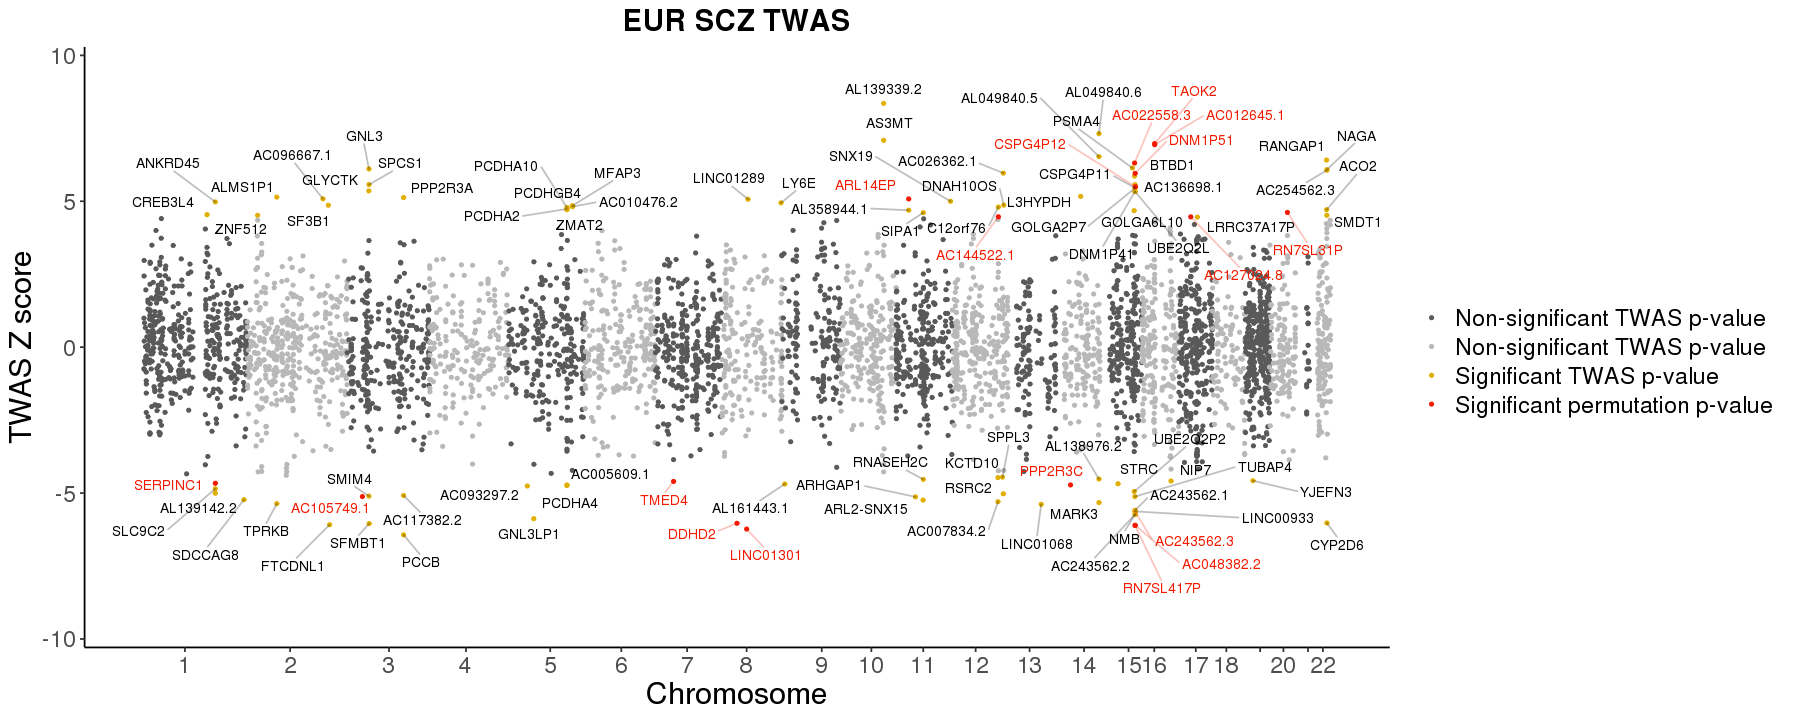

In [104]:
chr_labs <- c(1:18, '', 20, '', 22)
ylimit <- max(abs(dat_rn$TWAS.Z)) + 1
colors <- c("1" = "gray35", "2" = "gray72", "3" = "#E1AF00", "4" = "#F21A00")

options(repr.plot.height = 6, repr.plot.width = 15)

p <- ggplot(dat_rn, aes(x = pos, y = TWAS.Z, colour = as.character(color_group))) +
  geom_point(size = 0.8) +
  scale_x_continuous(name = "Chromosome", labels = chr_labs, breaks = ticks) +
  scale_y_continuous(name = "TWAS Z score", limits = c(-ylimit, ylimit)) +
  scale_colour_manual(values = colors, 
                      labels = c("Non-significant TWAS p-value","Non-significant TWAS p-value",
                                 "Significant TWAS p-value", "Significant permutation p-value")) +
#   geom_point(data = sig2, aes(x = pos, y = TWAS.Z), 
#              colour = ifelse(sig2$perm.pass == 1, "#F21A00", "#E1AF00"), size = 0.8) +
  geom_text_repel(data = sig2_rn, aes(x = pos, y = TWAS.Z, label = ID), 
                  colour = ifelse(sig2_rn$perm_pass == 1, "#F21A00", "black"), 
                  nudge_y = ifelse(sig2_rn$TWAS.Z > 0, .5, -.5), size = 3, force = 5, segment.alpha = 0.25) +
  theme_classic() +
  labs(title = "EUR SCZ TWAS", colour = "") +
  theme(axis.text = element_text(size = 14),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        legend.text = element_text(size = 14))

p

In [106]:
sum(sig$ID %in% sig_rn$ID)

[1] 95

In [108]:
sum(sig_perm$ID %in% sig_perm_rn$ID)

[1] 12

In [109]:
ggsave("figures/assoc_EUR_rn_SCZ.png", p, width = 15, height = 6)